### 03_Deprivation_Demographics_Analysis_SW

This notebook enriches the pre-processed South West LSOA spatial data with deprivation and demographic attributes.
Key tasks:
- Load South West LSOA GeoPackage (from Notebook 1)
- Merge with Index of Multiple Deprivation (IMD 2019)
- Merge with Local Authority District (LAD) lookup (2022)
- Merge with Rural-Urban Classification (RUC 2021)
- Exploratory analysis & basic visualizations

Outputs:
- Enriched LSOA GeoPackage for NHS SW region
- Plots and summary statistics for IMD, LAD, and RUC

In [1]:
## Imports and config

import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as ctx
import warnings

sns.set(style="whitegrid", palette="pastel")
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Paths
BASE_DIR = "/Users/rosstaylor/Downloads/Research Project/Code Folder/Research Project - Geospatial Health Demand"
RAW_DATA_DIR = os.path.join(BASE_DIR, "data", "raw")
PROCESSED_DATA_DIR = os.path.join(BASE_DIR, "data", "processed")

LSOA_SW_INPUT = os.path.join(PROCESSED_DATA_DIR, "lsoa_south_west.gpkg")
IMD_PATH = os.path.join(RAW_DATA_DIR, "Index_of_Multiple_Deprivation_(Dec_2019)_Lookup_in_England.csv")
LAD_LOOKUP_PATH = os.path.join(RAW_DATA_DIR,
                               "LSOA_(2011)_to_LSOA_(2021)_to_Local_Authority_District_(2022)_Exact_Fit_Lookup_for_EW_(V3).csv")
RUC_PATH = os.path.join(RAW_DATA_DIR, "Rural_Urban_Classification_(2021)_of_LSOAs_in_EW.csv")
ENRICHED_OUTPUT = os.path.join(PROCESSED_DATA_DIR, "lsoa_sw_enriched_demographics.gpkg")


In [2]:
## Step 1: Load South West LSOAs

assert os.path.exists(LSOA_SW_INPUT), "Run Notebook 1 first to generate South West LSOA file."
lsoa_sw_gdf = gpd.read_file(LSOA_SW_INPUT, layer="lsoa_south_west")
print(f"Loaded {len(lsoa_sw_gdf)} LSOAs for NHS South West region.")
lsoa_sw_gdf.head()


Loaded 3472 LSOAs for NHS South West region.


,LSOA21CD,LSOA21NM,LSOA21NMW,BNG_E,BNG_N,LAT,LONG,Shape__Are,Shape__Len,GlobalID,geometry
0,E01014014,Herefordshire 018C,None,363652,243381,52.08759,-2.53190,5.488187e+07,58635.757515,8fce111a-0aab-4f99-8777-1ed10d8b04b0,GEOMETRYCOLLECTION (POLYGON ((368107.008 23624...
1,E01014031,Herefordshire 023A,None,354699,217612,51.85525,-2.65915,1.949198e+07,28805.195706,77655486-1b21-4c99-a981-4f2fdb43ed95,GEOMETRYCOLLECTION (POLYGON ((356772.719 21580...
2,E01014032,Herefordshire 023B,None,359935,220422,51.88092,-2.58346,2.453930e+07,36178.876984,4a1dd37e-371d-4132-baa1-1e69fb6fd97d,GEOMETRYCOLLECTION (POLYGON ((363208.682 21811...
3,E01014036,Herefordshire 019B,None,371929,235664,52.01869,-2.41047,3.748703e+07,48290.644074,0a8efab5-acb9-44b2-acf0-e6a8d4bb460e,GEOMETRYCOLLECTION (POLYGON ((375978.965 23592...
4,E01014053,Herefordshire 023E,None,361436,228669,51.95517,-2.56258,4.982019e+07,49048.114559,61801e80-9228-4eed-962c-96a7143de5b7,"MULTILINESTRING ((365681.829 229234.482, 36569..."


LSOAs missing IMD: 246


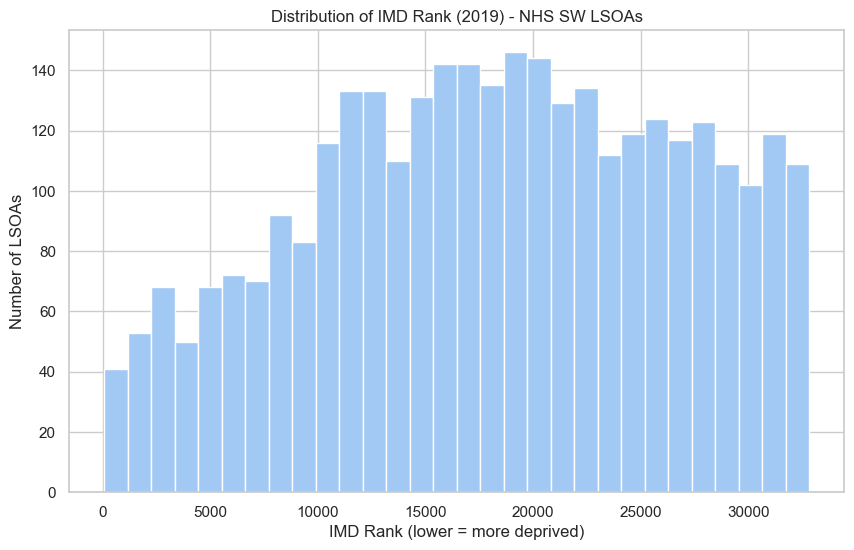

In [6]:
## Step 2: Merge Index of Multiple Deprivation (IMD) 2019

imd_df = pd.read_csv(IMD_PATH)
imd_df = imd_df.rename(columns={
    "LSOA11CD": "LSOA21CD",     # Map old to new for join
    "IMD19": "IMD_Rank"
})
imd_df = imd_df[["LSOA21CD", "IMD_Rank"]]
imd_df["LSOA21CD"] = imd_df["LSOA21CD"].astype(str).str.strip()


# Merge
lsoa_sw_gdf = lsoa_sw_gdf.merge(imd_df, on="LSOA21CD", how="left")
print(f"LSOAs missing IMD: {lsoa_sw_gdf['IMD_Rank'].isna().sum()}")

# Quick IMD plot
plt.figure(figsize=(10, 6))
lsoa_sw_gdf['IMD_Rank'].hist(bins=30)
plt.title("Distribution of IMD Rank (2019) - NHS SW LSOAs")
plt.xlabel("IMD Rank (lower = more deprived)")
plt.ylabel("Number of LSOAs")
plt.show()


In [7]:
## Step 3: Merge Local Authority District (LAD) lookup

lad_lookup = pd.read_csv(LAD_LOOKUP_PATH)
lad_lookup = lad_lookup[["LSOA21CD", "LAD22CD", "LAD22NM"]]
lad_lookup["LSOA21CD"] = lad_lookup["LSOA21CD"].astype(str).str.strip()
lsoa_sw_gdf = lsoa_sw_gdf.merge(lad_lookup, on="LSOA21CD", how="left")
print(f"Unique LADs in SW: {lsoa_sw_gdf['LAD22NM'].nunique()}")


Unique LADs in SW: 40


In [9]:
# Print the columns in the RUC file to check actual names
ruc_df = pd.read_csv(RUC_PATH, encoding="latin1")
print(ruc_df.columns.tolist())
ruc_df.head()


['ï»¿LSOA21CD', 'LSOA21NM', 'LSOA21NMW', 'RUC21CD', 'RUC21NM', 'Urban_rural_flag', 'ObjectId']


,ï»¿LSOA21CD,LSOA21NM,LSOA21NMW,RUC21CD,RUC21NM,Urban_rural_flag,ObjectId
0,E01000001,City of London 001A,NaN,UN1,Urban: Nearer to a major town or city,Urban,1
1,E01000002,City of London 001B,NaN,UN1,Urban: Nearer to a major town or city,Urban,2
2,E01000003,City of London 001C,NaN,UN1,Urban: Nearer to a major town or city,Urban,3
3,E01000005,City of London 001E,NaN,UN1,Urban: Nearer to a major town or city,Urban,4
4,E01000006,Barking and Dagenham 016A,NaN,UN1,Urban: Nearer to a major town or city,Urban,5


In [10]:
# ## Step 4: Merge Rural-Urban Classification (RUC)

# 1. Load the RUC CSV and clean the column names for BOM issues
ruc_df = pd.read_csv(RUC_PATH, encoding="latin1")

# Fix possible BOM character in first column name (common in ONS data)
if ruc_df.columns[0].startswith("ï»¿"):
    ruc_df = ruc_df.rename(columns={ruc_df.columns[0]: "LSOA21CD"})

# 2. Ensure LSOA21CD is string type and stripped
ruc_df["LSOA21CD"] = ruc_df["LSOA21CD"].astype(str).str.strip()

# 3. Create a binary Urban/Rural flag from the detailed RUC description
ruc_df["Urban_rural_flag"] = ruc_df["RUC21NM"].apply(
    lambda x: "Urban" if "Urban" in str(x) else ("Rural" if "Rural" in str(x) else "Other")
)

# 4. Merge into the main LSOA GeoDataFrame
lsoa_sw_gdf = lsoa_sw_gdf.merge(
    ruc_df[["LSOA21CD", "RUC21NM", "Urban_rural_flag"]],
    on="LSOA21CD", how="left"
)

# 5. Quick diagnostic: Print Urban/Rural counts after merge
print("Urban/Rural classification counts in South West LSOAs:")
print(lsoa_sw_gdf["Urban_rural_flag"].value_counts(dropna=False))


Urban/Rural classification counts in South West LSOAs:
Urban_rural_flag
Urban    2417
Other    1058
Name: count, dtype: int64


In [11]:
## Step 5: Save enriched LSOA file for next steps

lsoa_sw_gdf.to_file(ENRICHED_OUTPUT, driver="GPKG", layer="lsoa_sw_enriched_demographics")
print(f"Saved enriched LSOA GeoPackage: {ENRICHED_OUTPUT}")


Saved enriched LSOA GeoPackage: /Users/rosstaylor/Downloads/Research Project/Code Folder/Research Project - Geospatial Health Demand/data/processed/lsoa_sw_enriched_demographics.gpkg


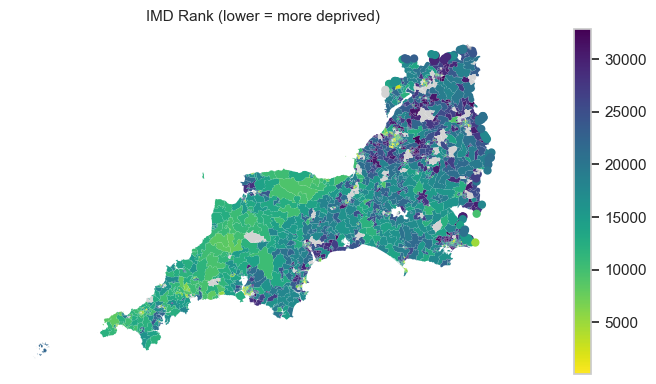

In [18]:
## Quick Map—IMD Rank and Rural/Urban
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

fig, ax = plt.subplots(1, 1, figsize=(12, 4))  # Single axis

# IMD Rank map
lsoa_sw_gdf.plot(
    column="IMD_Rank",
    ax=ax,
    cmap="viridis_r",
    legend=True,
    edgecolor="none",
    missing_kwds={"color": "lightgrey", "label": "Missing"}
)
ax.set_title("IMD Rank (lower = more deprived)", fontsize=11)
ax.axis("off")

plt.tight_layout()
plt.show()


RUC21NM
Urban: Nearer to a major town or city               1820
Urban: Further from a major town or city             597
Smaller rural: Further from a major town or city     362
Larger rural: Further from a major town or city      277
Smaller rural: Nearer to a major town or city        229
Larger rural: Nearer to a major town or city         190
Name: count, dtype: int64


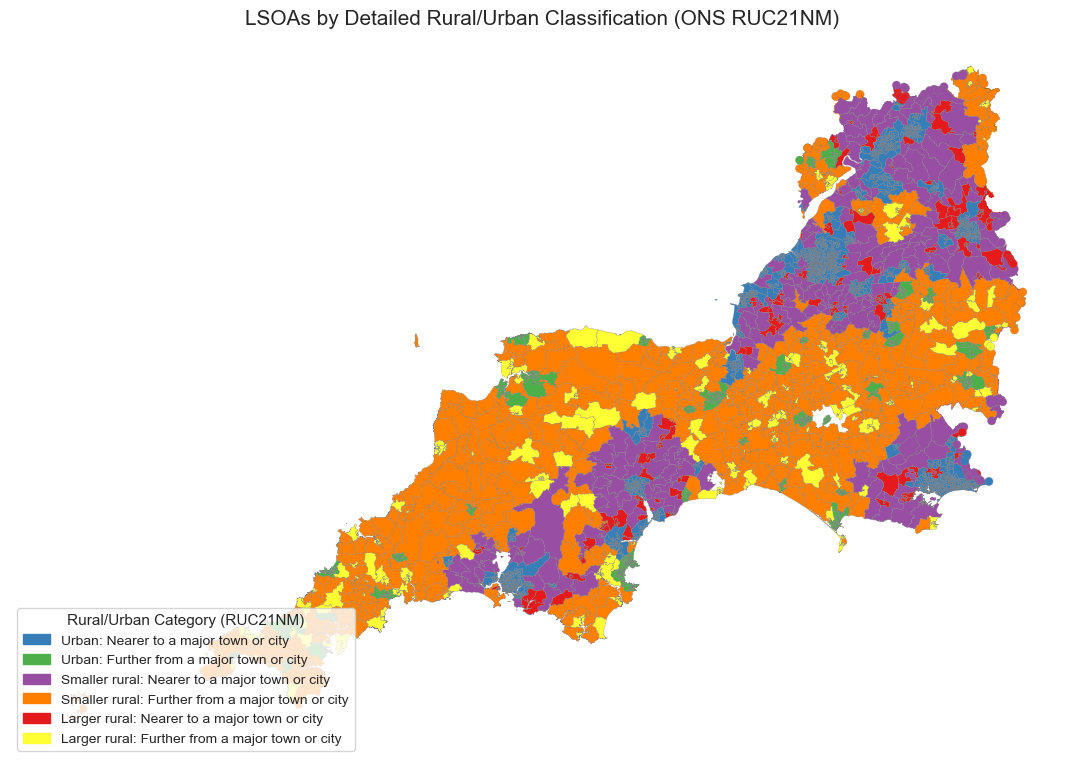

In [19]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Define a fixed colour map for each RUC21NM phrase
ruc_palette = {
    "Urban: Nearer to a major town or city": "#377eb8",      # Blue
    "Urban: Further from a major town or city": "#4daf4a",   # Green
    "Smaller rural: Nearer to a major town or city": "#984ea3",  # Purple
    "Smaller rural: Further from a major town or city": "#ff7f00",  # Orange
    "Larger rural: Nearer to a major town or city": "#e41a1c",  # Red
    "Larger rural: Further from a major town or city": "#ffff33",  # Yellow
}

# Optional: Check your data actually contains these categories
print(lsoa_sw_gdf["RUC21NM"].value_counts())

# Create the plot
fig, ax = plt.subplots(figsize=(11, 8))
lsoa_sw_gdf.plot(
    column="RUC21NM",
    ax=ax,
    color=lsoa_sw_gdf["RUC21NM"].map(ruc_palette),
    edgecolor="grey",
    linewidth=0.2,
    legend=False
)

# Custom legend patches
legend_patches = [
    mpatches.Patch(color=color, label=label)
    for label, color in ruc_palette.items()
]
ax.legend(
    handles=legend_patches,
    title="Rural/Urban Category (RUC21NM)",
    loc="lower left",
    fontsize=10,
    title_fontsize=11,
    frameon=True
)

ax.set_title("LSOAs by Detailed Rural/Urban Classification (ONS RUC21NM)", fontsize=15)
ax.axis("off")
plt.tight_layout()
plt.show()
